In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

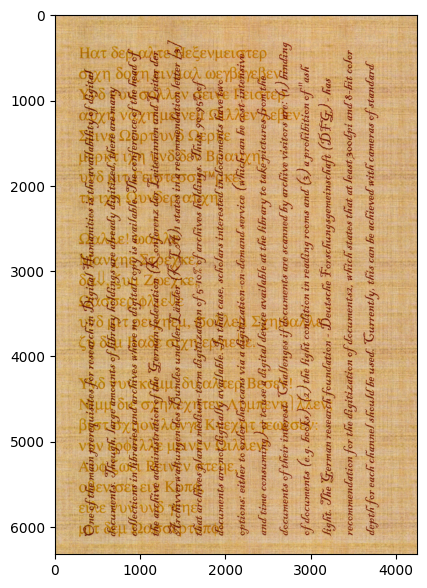

In [2]:
image = cv2.imread('./palimpsest-2024.jpg')

plt.figure(figsize=(15, 7))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
blue_channel, green_channel, red_channel = cv2.split(image)

In [4]:
matrices = [blue_channel, green_channel, red_channel]
max_diff = 0
max_indices = (0, 0)

for i in range(len(matrices)):
    for j in range(i+1, len(matrices)):
        diff = np.sum(np.abs(matrices[i] - matrices[j]))
        if diff > max_diff:
            max_diff = diff
            max_indices = (i, j)

matrix_with_max_diff1 = matrices[max_indices[0]]
matrix_with_max_diff2 = matrices[max_indices[1]]

Matrices with the highest difference:
[[195 194 191 ... 162 166 166]
 [187 188 193 ... 166 166 166]
 [188 187 190 ... 166 165 165]
 ...
 [168 170 171 ... 177 178 177]
 [171 171 174 ... 180 180 180]
 [175 175 177 ... 179 179 179]]
[[227 226 223 ... 198 202 202]
 [219 220 225 ... 202 202 202]
 [219 218 222 ... 202 202 202]
 ...
 [208 207 208 ... 213 216 214]
 [208 206 209 ... 216 216 216]
 [210 210 212 ... 216 215 215]]


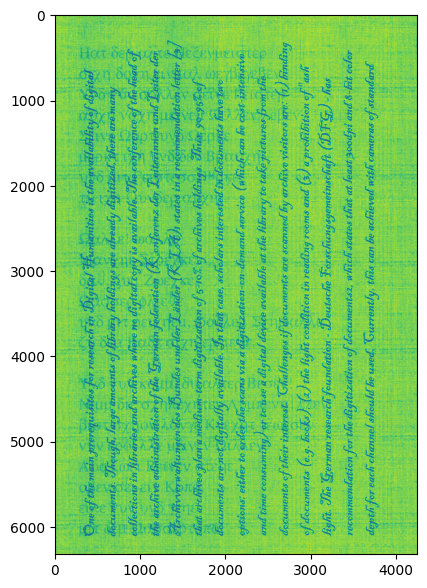

In [5]:
plt.figure(figsize=(15, 7))
plt.imshow(red_channel)
plt.show()

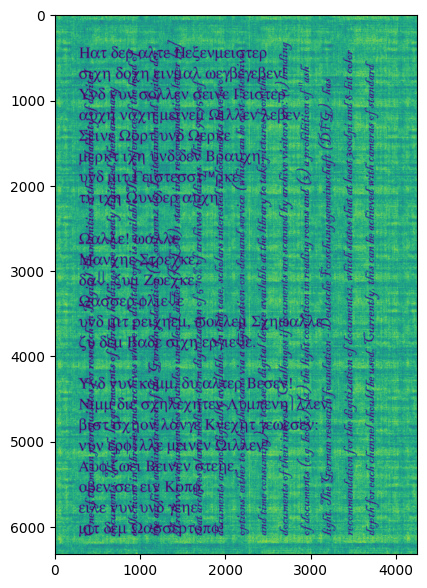

In [6]:
plt.figure(figsize=(15, 7))
plt.imshow(blue_channel)
plt.show()

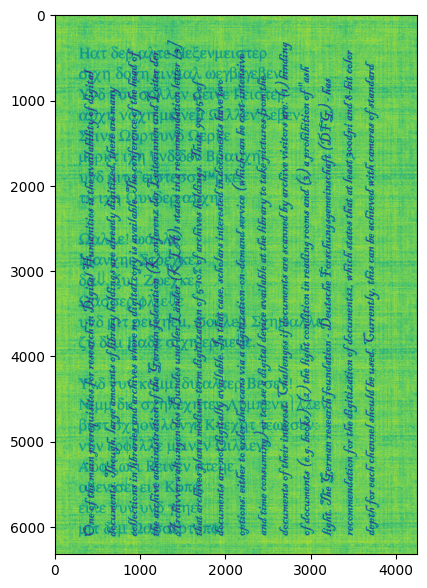

In [7]:
plt.figure(figsize=(15, 7))
plt.imshow(green_channel)
plt.show()

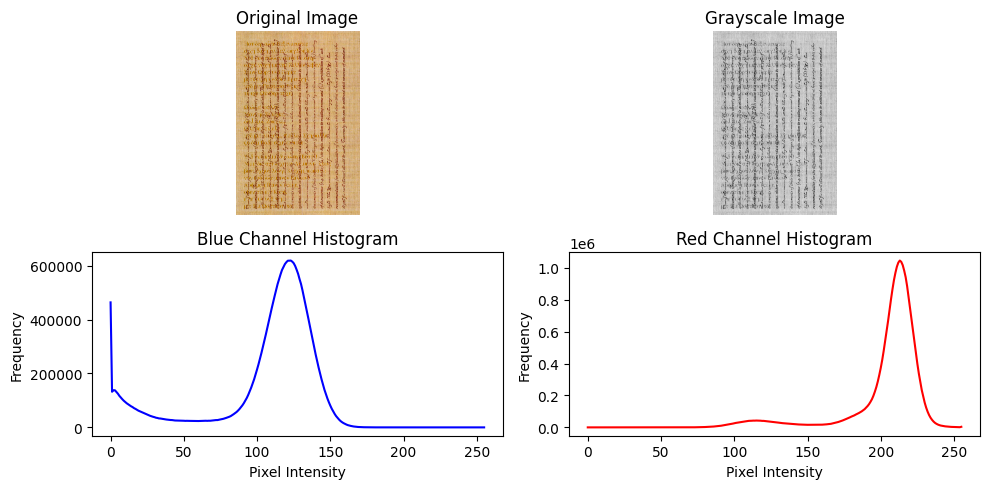

In [90]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Calculate histograms for each channel
hist_blue = cv2.calcHist([image], [0], None, [256], [0, 256])
hist_green = cv2.calcHist([image], [1], None, [256], [0, 256])
hist_red = cv2.calcHist([image], [2], None, [256], [0, 256])

# Plot histograms
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.plot(hist_blue, color='blue')
plt.title('Blue Channel Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.plot(hist_red, color='red')
plt.title('Red Channel Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Red and Blue channels have the highest difference


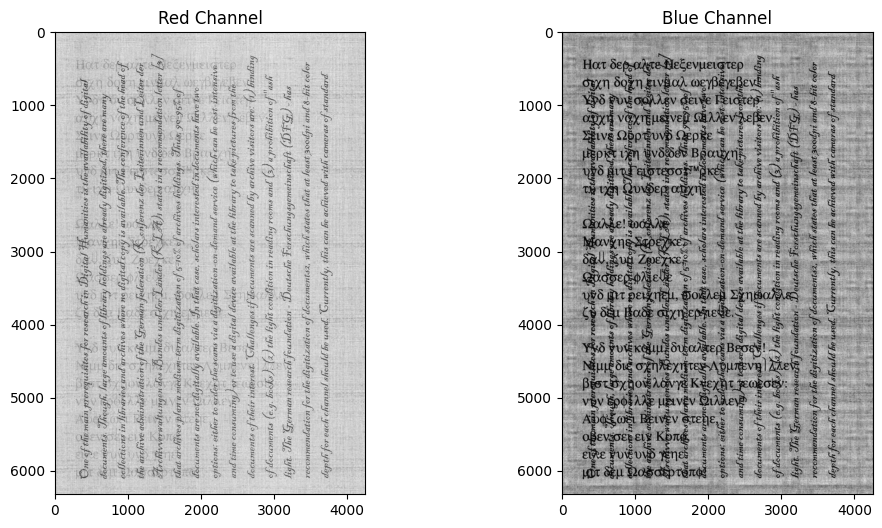

In [92]:
def channel_difference(chan1, chan2):
    return np.sum(np.abs(chan1 - chan2))

rg_diff = channel_difference(red_channel, green_channel)
rb_diff = channel_difference(red_channel, blue_channel)
gb_diff = channel_difference(green_channel, blue_channel)

# Determine which two channels have the maximum difference
max_diff = max(rg_diff, rb_diff, gb_diff)
if max_diff == rg_diff:
    ch1, ch2 = red_channel, green_channel
    print("Red and Green channels have the highest difference")
elif max_diff == rb_diff:
    ch1, ch2 = red_channel, blue_channel
    print("Red and Blue channels have the highest difference")
else:
    ch1, ch2 = green_channel, blue_channel
    print("Green and Blue channels have the highest difference")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Red Channel")
plt.imshow(ch1, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Blue Channel")
plt.imshow(ch2, cmap='gray')
plt.show()

In [80]:
underwriting_coords = (385, 427, 169, 108)
overwriting_coords = (880, 590, 107, 18)
parchment_coords = (491, 297, 215, 184)

def calculate_mean_gray_values(channel, coords):
    start_row, start_col, height, width = coords
    region = channel[start_row:start_row+height, start_col:start_col+width]
    return np.mean(region)

mean_red_parchment = calculate_mean_gray_values(red_channel, parchment_coords)
mean_green_parchment = calculate_mean_gray_values(green_channel, parchment_coords)
mean_blue_parchment = calculate_mean_gray_values(blue_channel, parchment_coords)

mean_red_overwriting = calculate_mean_gray_values(red_channel, overwriting_coords)
mean_green_overwriting = calculate_mean_gray_values(green_channel, overwriting_coords)
mean_blue_overwriting = calculate_mean_gray_values(blue_channel, overwriting_coords)

contrast_red = mean_red_overwriting - mean_red_parchment
contrast_green = mean_green_overwriting - mean_green_parchment

scale_factor_red = 1  # Keep red as baseline
scale_factor_green = contrast_red / contrast_green if contrast_green != 0 else 1

print(f"Scale Factor for Red: {scale_factor_red}")
print(f"Scale Factor for Green: {scale_factor_green}")

Scale Factor for Red: 1
Scale Factor for Green: 0.4694270592633101


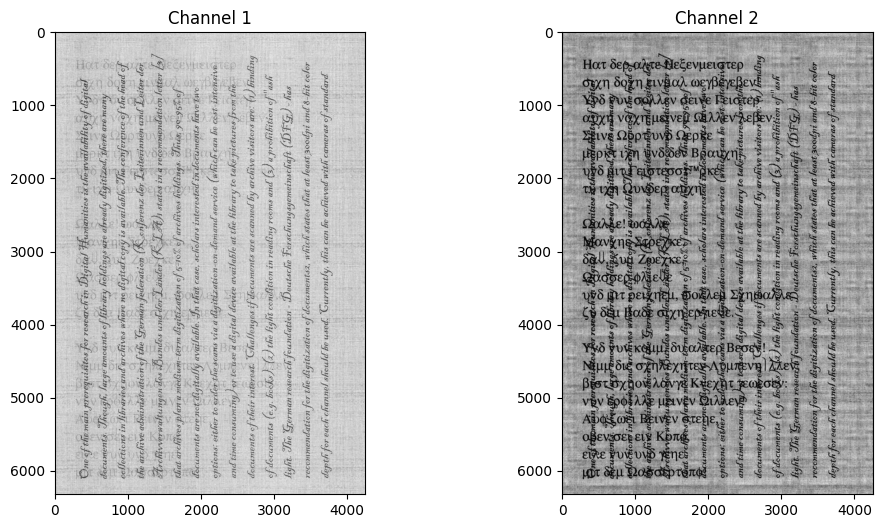

In [81]:
# Scale the channels (example scale factors, adjust based on analysis)
scale_factor1 = 1
scale_factor2 = 0.47
scaled_ch1 = ch1 * scale_factor1
scaled_ch2 = ch2 * scale_factor2

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Channel 1")
plt.imshow(scaled_ch1, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Channel 2")
plt.imshow(scaled_ch2, cmap='gray')
plt.show()

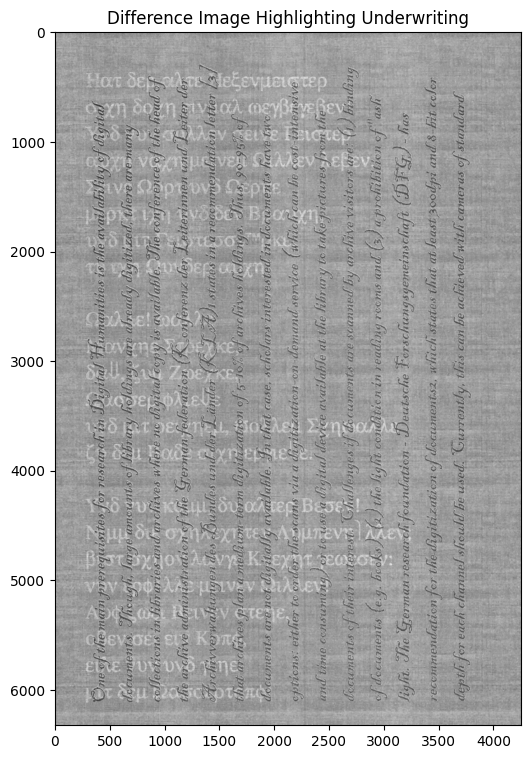

In [82]:
scaled_red_channel = np.clip(scaled_ch1, 0, 255).astype(np.uint8)
scaled_green_channel = np.clip(scaled_ch2, 0, 255).astype(np.uint8)

# Subtract the channels
difference_image = cv2.absdiff(scaled_red_channel, scaled_green_channel)

plt.figure(figsize=(16, 9))
plt.title("Difference Image Highlighting Underwriting")
plt.imshow(difference_image, cmap='gray')
plt.show()

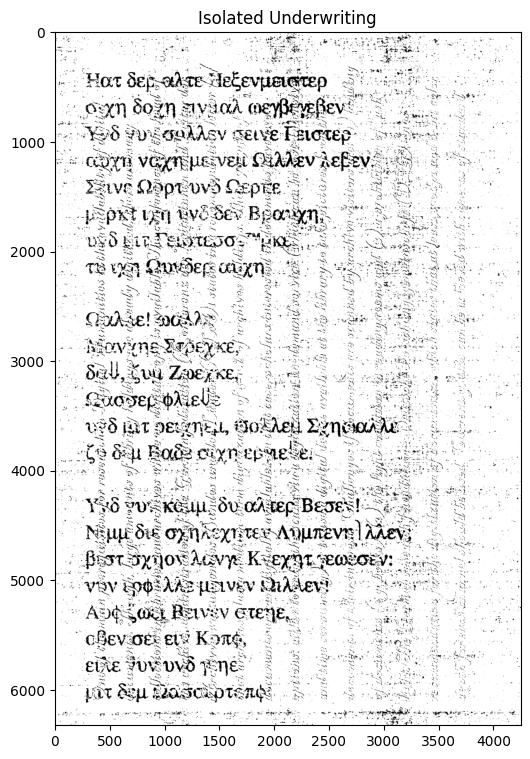

In [88]:
overwritting, underwriting_mask = cv2.threshold(difference_image, 170, 250, cv2.THRESH_BINARY_INV)

underwriting = cv2.bitwise_and(difference_image, underwriting_mask)
overwritting, underwriting_only = cv2.threshold(underwriting, 170, 255, cv2.THRESH_BINARY_INV)
# underwriting_only = cv2.bitwise_and(difference_image, underwriting_mask)

plt.figure(figsize=(16, 9))
plt.title("Isolated Underwriting")
plt.imshow(underwriting_mask, cmap='gray')
plt.show()